## Project: What we can learn from visitors visiting Taiwan from 2011 to 2023

The original dataset is available from [Taiwan Tourism Bureau](https://stat.taiwan.net.tw/)

### Introduction:
The data was downloaded from Taiwan Tourism Bureau. It contains the monthly number of visitors to Taiwan by their gender, residence and purpose.

### Background:
Taiwan's travel and tourism industry plays a significant role in its economy, contributing to economic growth, job creation, and cultural exchange. The foreign exchange earnings from tourism for the year 2019 were estimated to be 14.41 billion US dollars, which was 4.43% of Taiwan's GDP. The total number of visitors to Taiwan in 2019 also reached an all-time-high record, 11.85 million.

The goal is to determine whether visitors to Taiwan are increasing, declining or being stagnant and to build a time series model that forecasts the future from the perspective of the past.

**In this notebook, we will focus on Pre-processing Work & Modeling.**

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Add the dataset from a csv file
total_by_month = pd.read_csv('../Data/total_by_month.csv')
total_by_month

,Period,Total
0,2011-01-01,373493
1,2011-02-01,422541
2,2011-03-01,502960
3,2011-04-01,533934
4,2011-05-01,455628
...,...,...
150,2023-07-01,541238
151,2023-08-01,588117
152,2023-09-01,536338
153,2023-10-01,618184


In [3]:
# Call the info method to see a summary of the data
total_by_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Period  155 non-null    object
 1   Total   155 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.6+ KB


There are 155 rows and 2 columns in this Pandas dataframe with no null values. We will furhter convert this dataframe into a series and with the `Period` column as the new index.

In [4]:
# Type conversion
total_by_month['Period'] = pd.to_datetime(total_by_month['Period'], format='%Y-%m-%d')
total_by_month.set_index('Period', inplace=True)
total_by_month

,Total
Period,
2011-01-01,373493
2011-02-01,422541
2011-03-01,502960
2011-04-01,533934
2011-05-01,455628
...,...
2023-07-01,541238
2023-08-01,588117
2023-09-01,536338


In [5]:
# Making a predictor variable y
y = total_by_month['Total']
type(y)

pandas.core.series.Series

In [6]:
# Get a summary statitics for y
y.describe()

count    1.550000e+02
mean     6.057653e+05
std      3.483379e+05
min      2.555000e+03
25%      4.305340e+05
50%      6.913320e+05
75%      8.660075e+05
max      1.142198e+06
Name: Total, dtype: float64

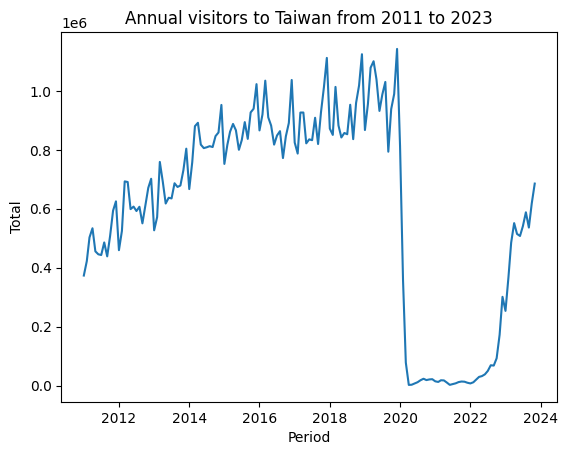

In [7]:
# Plot the data
_ = sns.lineplot(x=y.index, y =y)
plt.title('Annual visitors to Taiwan from 2011 to 2023')
plt.show()

In our previos EDA, we already learned that there is a upward trend in visitors to Taiwan from 2011 to 2023 despite a drastic downturn in 2020 due to the Covid-19. There is also a seasonal pattern in the total number of visitors with a repeated pattern. Because the general trend does not increase at a steady speed and the amplitude of seasonal fluctuations gets bigger as time progresses, our data should be multiplicative.

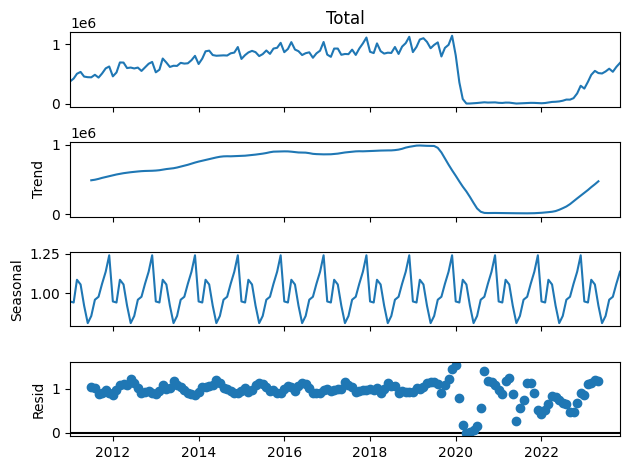

In [8]:
# Decomposition
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')

# Plot the original data, the trend, the seasonality, and the residuals 
decomposition.plot()
plt.show()

We have to assess stationarity when performing time series analysis. A time series dataset is deemed stationary when its statistical characteristics remain constant over time, which means the series exhibits a consistent mean, variance, and covariance.

KPSS is one of the most widely used methods for testing stationarity. The null hypothesis of the KPSS test suggests that the examined time series data is stationary. Therefore, if the p-value falls below the chosen significance level (typically 0.05), we reject the null hypothesis and conclude that the data lacks stationarity.

In [9]:
# Testing for stationarity with KPSS
from statsmodels.tsa.stattools import kpss
kpss(y)

(0.5936458037914313,
 0.02321401783714261,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. However, we need our data to be stationary before building a predictive model.

Alternatively, we can check stationarity using the Dicky-Fuller test. The Null hypothesis of this test is that the time series data has a unit root, indicating it is non-stationary. If the *p*-value is less than the significance level, we reject the Null and infer that the data is stationary. Keep in mind that **a significant *p*-value means stationary in `adfuller()` but opposite in `kpss()`.**

In [10]:
# Testing for stationarity with Dicky-Fuller
from statsmodels.tsa.stattools import adfuller
adfuller(y)

(-1.7986894725554257,
 0.38111252795536865,
 13,
 141,
 {'1%': -3.4776006742422374,
  '5%': -2.882265832283648,
  '10%': -2.5778219289774156},
 3564.7780652438382)

Since our p-value is larger than 0.05, we could not reject the Null hypothesis and deduce the non-stationarity of our data, which is consistent with KPSS.

<AxesSubplot: xlabel='Period'>

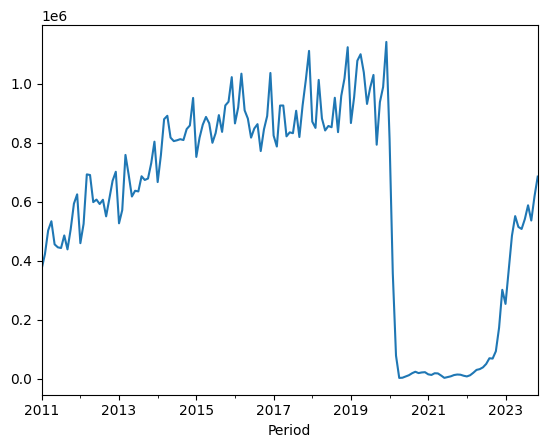

In [11]:
# Plot the data
y.plot()

It is evident that both the mean and variance increase over time, which suggests that our data lacks a consistent mean and variance. As a result, we will have to transform our data and make it stationary.

<AxesSubplot: xlabel='Period'>

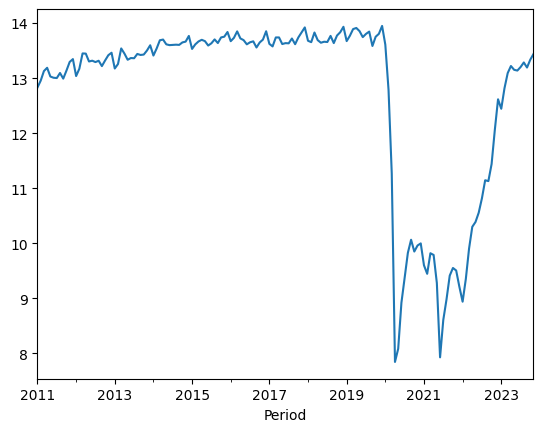

In [12]:
# Natural log transformation
y_log = np.log(y)
y_log.plot()


We can see that the variance in our data now remains more contant over time than that before transformation.

In [13]:
# Testing for stationarity with KPSS after natural log transformation
kpss(y_log)

(0.6956744098051777,
 0.013938690017711117,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Although we have a constant variance, we also need a constant mean. At this moment, our p-value of KPSS test is still less than 0.05, indicating non-stationarity.

We can achieve a constant mean by differencing our data. Differencing involves creating a new time series that represents the difference between consecutive values in our existing dataset.

We can use the `diff()` function for this purpose. It is important to note that the resulting differenced series will have one less value than our original dataset.


In [14]:
# Differencing by using diff() function
y_log.diff()

Period
2011-01-01         NaN
2011-02-01    0.123387
2011-03-01    0.174224
2011-04-01    0.059762
2011-05-01   -0.158596
                ...   
2023-07-01    0.063815
2023-08-01    0.083067
2023-09-01   -0.092161
2023-10-01    0.142022
2023-11-01    0.103303
Name: Total, Length: 155, dtype: float64

/var/folders/4s/dkhgvddx5kb346fv_thq5bqh0000gn/T/ipykernel_54585/2324392966.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(y_log.diff().dropna())


(0.10228302901800786,
 0.1,
 1,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

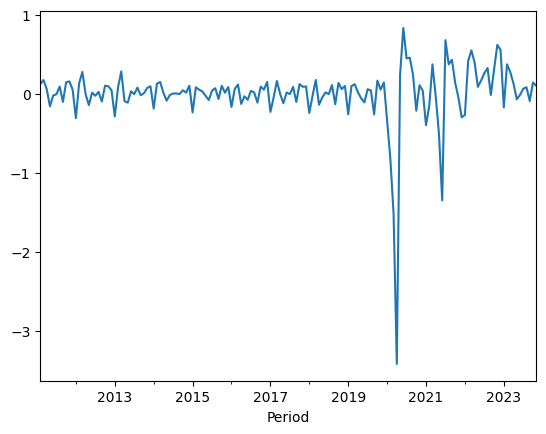

In [15]:
# Testing for stationarity with KPSS after natural log transformation and differencing
y_log.diff().dropna().plot()
kpss(y_log.diff().dropna())

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

In [16]:
# Testing for stationarity with Dicky-Fuller after natural log transformation and differencing
adfuller(y_log.diff().dropna())

(-8.216370141821006,
 6.607429612093402e-13,
 1,
 152,
 {'1%': -3.474120870218417,
  '5%': -2.880749791423677,
  '10%': -2.5770126333102494},
 126.98742877512208)

When we use `adfuller()`, p-value is much smaller than 0.05, suggesting that we could reject the Null hypothesis and our data is stationary (not a random walk). In this case since both tests indicate stationarity, the series can be deemed to be trend-stationary. Trend-stationarity implies difference-stationarity, but the reverse is not necessarily true. Keep in mind that if the KPSS test indicates stationarity and the Dicky-Fuller test indicates non-stationarity, it's a sign that the series is only difference-stationary. 

Using both tests ensures us that we avoid misinterpreting the type of stationarity or the presence of a trend in the data. In practice, the goal is often to make the data either difference-stationary, trend-stationary, or both, depending on the characteristics of the time series. Many time series models, like the popular ARIMA (AutoRegressive Integrated Moving Average) model, are designed to work with difference-stationary data. These models often involve differencing the original series to achieve stationarity.

White noise is a special case of a stationary time series. It is characterized by a constant mean, a constant variance and no autocorrelation. However, it is also characterized by its lack of discernible patterns, structure, or correlations between observations. Because of its randomness and lack of patterns, white noise is inherently difficult to predict. Therefore, we will further examine the Autocorrelation Function (ACF) plot of our data.

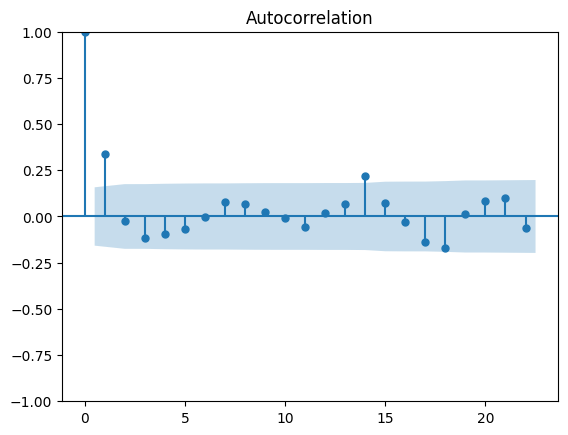

In [17]:
# Plot the autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y_log.diff().dropna())
plt.show()


There is at least one lag, other than lag 0, is significantly different from zero in the ACF, which suggests the presence of autocorrelation in our time series data. Because autocorrelation is detected, it might be appropriate to consider more complex models that capture the temporal dependencies in the data. This could involve ARIMA models or other sophisticated time series models.

In [18]:
# Import mean_squared_error, mean_absolute_error and ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

In order to generate an ARIMA model, we have to estimate the order of the model. There are multiple ways to find good parameters of our model, e.q. using Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to choose model order. However, ACF and PACF rarely gave us a conclusive model choice in my experience and we should always loop over multiple parameters to find the best model order. Herein, we will try the following two ways to identify the optimal order of an ARIMA model. 

The first method is to calculate the root mean squared error (RMSE) and mean absolute error (MAE) between our predictions and true values. We implemented the one-step approach to calculate RMSE and MAE because it provides a more dynamic and accurate measure of the model's performance in a real-world scenario. In this approach, predictions are made, true values are observed, and subsequent predictions are then generated. The resulting RMSE/MAE calculated through this method offers a potentially more precise representation of the model's out-of-sample performance, capturing the nuances of the prediction-observation process in a dynamic setting. 

In [19]:
# Make a function to calculate RMSE and MAE of a single ARIMA model
def RMSE_MAE (data, ARIMA_order):
    split = int(len(data)*0.8)
    y_train, y_test = data[:split], data[split:]
    y_pred = []
    y_train = list(y_train)
    #timestep-wise comparison between test data and one-step prediction ARIMA model.
    for i in range(len(y_test)):
        model = ARIMA(y_train, order=ARIMA_order)
        result = model.fit()
        future = result.forecast()[0]
        y_pred.append(future)
        y_train.append(y_test[i])
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return [rmse, mae]

In [20]:
# Make a function to evaluate different ARIMA models with different p, d, and q values by using RMSE and MAE
def ARIMA_eval_RMSEMAE (data, p_values, d_values, q_values): 
    order_RMSE_MAE=[]
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                # We use try here because we want to skip some orders that could cause non-stationary and lead to a fit error
                try:
                    score = RMSE_MAE(data, order)
                    order_RMSE_MAE.append((p, d, q, score[0], score[1]))
                except:
                    order_RMSE_MAE.append((p, d, q, None, None))
    order_df = pd.DataFrame(order_RMSE_MAE, columns=['p','d','q','RMSE','MAE'])
    return order_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True).style.highlight_min(color='lightgreen', axis=0, subset=['RMSE','MAE'])

The other tool is to look at the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). These measures compute the goodness of fit with the estimated parameters, but apply a penalty function on the number of parameters in the model. The main difference between AIC and BIC is how much they penalize the complexity of our model. AIC is often preferred when we have a larger sample size and are willing to accept slightly more complex models, while BIC is favored when we have a smaller sample size or when we want to strongly favor simplicity. 

In [21]:
# Make a function to evaluate different ARIMA models with different p, d, and q values by comparing AIC and BIC
def ARIMA_eval_AICBIC (data, p_values, d_values, q_values): 
    order_aic_bic=[]
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                # We use try here because we want to skip some orders that could cause non-stationary and lead to a fit error
                try:
                    model = ARIMA(data, order=order)
                    results = model.fit()
                    order_aic_bic.append((p, d, q, results.aic, results.bic))
                except:
                    order_aic_bic.append((p, d, q, None, None))
    order_df = pd.DataFrame(order_aic_bic, columns=['p','d','q','AIC','BIC'])
    return order_df.sort_values(by='BIC', ascending=True).reset_index(drop=True).style.highlight_min(color='lightgreen', axis=0, subset=['AIC','BIC'])

In [22]:
# Create a list of values of each ARIMA parameter
p_values = [0,1,2]
d_values = [0,1,2]
q_values = [0,1,2]

In [23]:
# Optimize ARIMA model by RMSE and MAE
import warnings
warnings.filterwarnings("ignore")
ARIMA_eval_RMSEMAE(y_log, p_values, d_values, q_values)

,p,d,q,RMSE,MAE
0,1,0,1,0.391368,0.278261
1,2,1,0,0.391819,0.274175
2,1,0,2,0.392018,0.275629
3,1,1,2,0.392148,0.280461
4,0,1,1,0.392511,0.271685
5,2,0,1,0.393123,0.277563
6,2,0,2,0.393376,0.276194
7,2,0,0,0.394184,0.272147
8,1,1,0,0.394255,0.275950
9,1,1,1,0.395430,0.272585


ARIMA(1, 0, 1) model has the lowest RMSE, 0.39137, while ARIMA(0, 1, 1) model has the lowest MAE, 0.27169.

In [24]:
# Optimize ARIMA model by AIC and BIC
ARIMA_eval_AICBIC (y_log, p_values, d_values, q_values)

,p,d,q,AIC,BIC
0,0,1,1,126.352402,132.426307
1,1,1,0,128.740083,134.813988
2,2,1,0,127.049990,136.160847
3,0,1,2,128.064826,137.175684
4,1,1,1,128.162109,137.272966
5,2,1,1,128.188567,140.336377
6,1,0,1,129.629363,141.803064
7,0,2,2,132.957332,142.048646
8,1,1,2,130.056610,142.204420
9,2,0,0,131.081584,143.255285


When we apply an AIC-BIC order search, the best p, d, q parameters for our ARIMA model are 0, 1, 1, which is consistent with the previous MAE approach. Keep in mind that AIC and BIC both favored the same model ARIMA(0, 1, 1) in this scenario, but this won't always be the case. 

We further examine the RMSE of this particular ARIMA(0, 1, 1) model, of which the RMSE is 0.39251 and quite comparable to the ARIMA(1, 0, 1) model. Given that MAE, AIC and BIC all favor the same model ARIMA(0, 1, 1), we will use the order (0, 1, 1) to build an ARIMA model and take a look at a summary of the model this library has built around our data.

In [25]:
# Build a single ARIMA model with the best parameter
p=0
d=1
q=1
model = ARIMA(y_log, order=(p,d,q))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                  155
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -61.176
Date:                Fri, 02 Feb 2024   AIC                            126.352
Time:                        15:36:03   BIC                            132.426
Sample:                    01-01-2011   HQIC                           128.820
                         - 11-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3668      0.030     12.290      0.000       0.308       0.425
sigma2         0.1295      0.004     30.729      0.000       0.121       0.138
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              6311.40
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):              21.79   Skew:                            -3.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on the summary p-value of Ljung-Box (L1) test, we cannot reject the null hypothesis of the test and should accept that there is no autocorrelation in the residuals of the time series. The L1 test is particularly employed to evaluate whether the residuals (or errors) of a time series model exhibit significant autocorrelation. If significant autocorrelations are detected, it indicates that there may be room for improvement in the model.

However, the p-value of the Jarque-Bera (JB) test in the summary is exactly zero, it typically indicates that the data's distribution significantly deviates from a normal distribution. The JB test is a statistical test for assessing the skewness and kurtosis of a sample, and it is often used to check the normality assumption of the residuals in a regression or time series model.

We can further examine other diagnostic plots and tests for residuals using `plot_diagnostics()`.

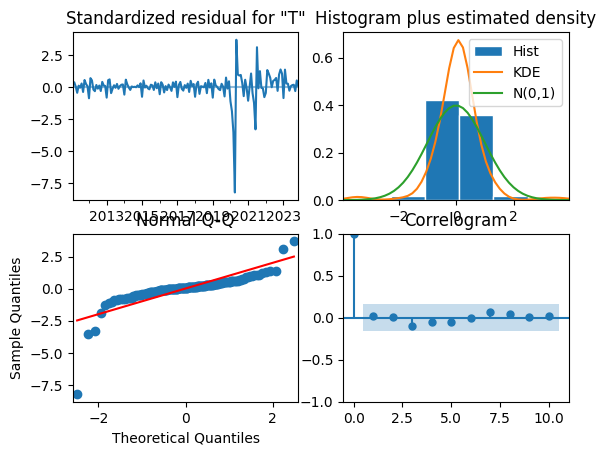

In [26]:
result.plot_diagnostics()
plt.show()

The histogram and Q-Q plots indeed both show that the residuals from our ARIMA model do not exactly follow a normal distribution. Typically, if the residuals are not normally distributed, we would consider revisiting the model and applying transformations to remove outliers. In this case, we acknowledge that the deviation was caused by an unprecedented and dramatic downturn in data, namely the onset of the global pandemic in early 2020. These sudden and unforeseen events pose a challenge to ARIMA, as the model struggles to effectively handle such extraordinary disruptions.

ARIMA models assume that the residuals are normally distributed. If the residuals are significantly non-normal, it may compromise the reliability of the model's parameter estimates and predictions. While ARIMA models are generally robust to departures from normality, severe deviations, akin to the impact of the COVID-19 outbreak, may considerably distress the model.

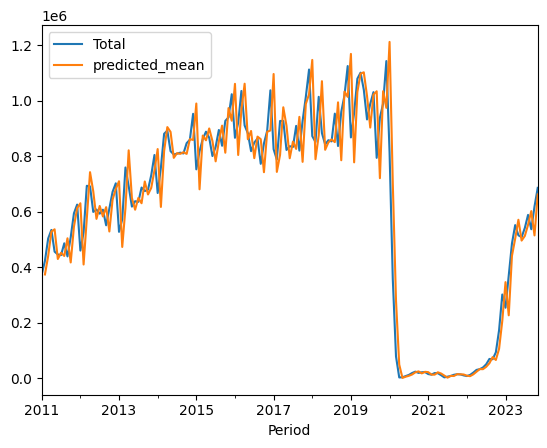

In [27]:
# Visualize the original dataset plotted against our model
fig, ax = plt.subplots()
y.plot(ax=ax)
np.exp(result.predict(start='2011-02-01', end='2023')).plot(ax=ax)
plt.legend()
plt.show()

It seems that our model fits tightly to our existing data. We will further use it to forecast the number of future visitors over the next 24 months.

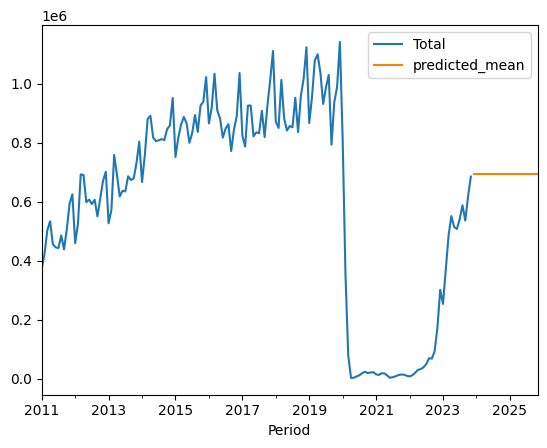

In [28]:
# Declare a variable called prediction with the amount of months to forecast
prediction = result.forecast(24)

# Convert the forecast into a dataframe that includes your actual numbers of prediction 
df = pd.DataFrame(np.exp(prediction))

# Plot your future predictions
fig, ax = plt.subplots()
y.plot(ax=ax)
np.exp(result.predict(start='2023-12-01', end='2025-11-01')).plot(ax=ax)
plt.legend()
plt.show()

We can see that ARIMA(0, 1, 1) forecasts more than one period in the future are simply equal to the first forecast of the sample. This issue could be attributed to the behavior of the ARIMA model and the chosen parameter settings. If the time series data does not contain sufficient information or exhibits randomness, the ARIMA model may struggle to discern meaningful patterns, leading to less informative forecasts.

Because this behavior makes the model less useful for long-term predictions, we should consider alternative models to improve its effectiveness in forecasting . Depending on the nature of the time series, other forecasting models (e.g., SARIMA, exponential smoothing methods) might be more appropriate. We should experiment with different models to find the one that best fits our data.

We will use PyCaret, a low-code machine learning library in Python that automates machine learning workflows, to explore the performance of different time series forecasting models and select the best one.

In [29]:
# Review our data
y.head()

Period
2011-01-01    373493
2011-02-01    422541
2011-03-01    502960
2011-04-01    533934
2011-05-01    455628
Name: Total, dtype: int64

In [30]:
# Import the module, initialize the training environment and create the transformation pipeline
from pycaret.time_series import *
exp = setup(data = y, fold = 5, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Total
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(155, 1)"
5,Transformed data shape,"(155, 1)"
6,Transformed train set shape,"(154, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


As you can see, the `setup()` function analyzes the time series data automatically and provides a detailed summary of global variables which highlights `seasonality`. We will use these default settings to compare various models in the library and generate a table of performance metrics.

In [31]:
# Use the compare_models() function to train and evaluate performance of all estimators available in the model library using cross validation
best = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.0763,0.0412,12750.7357,12750.7357,0.0231,0.0230,0.0100
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,0.0819,0.0443,13706.0791,13706.0791,0.0247,0.0245,0.0100
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,0.0819,0.0443,13706.0819,13706.0819,0.0247,0.0245,0.0100
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.0819,0.0443,13706.0792,13706.0792,0.0247,0.0245,0.0480
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.0819,0.0443,13706.0819,13706.0819,0.0247,0.0245,0.0280
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.0819,0.0443,13706.0792,13706.0792,0.0247,0.0245,0.1920
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.1034,0.0556,17171.2902,17171.2902,0.0311,0.0313,0.0120
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,0.1127,0.0608,18790.8405,18790.8405,0.0332,0.0338,0.0100
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.1142,0.0615,19007.4149,19007.4149,0.0338,0.0344,0.0100
ets,ETS,0.1215,0.0652,20115.6295,20115.6295,0.0369,0.0361,0.0180


In this experiment, the Bayesian Ridge model highlighted at the top exhibits the lowest error scores and outperforms all other models. Will it be the most suitable forecasting model for our data? We will plot the forecast for the next 24 months to find out.

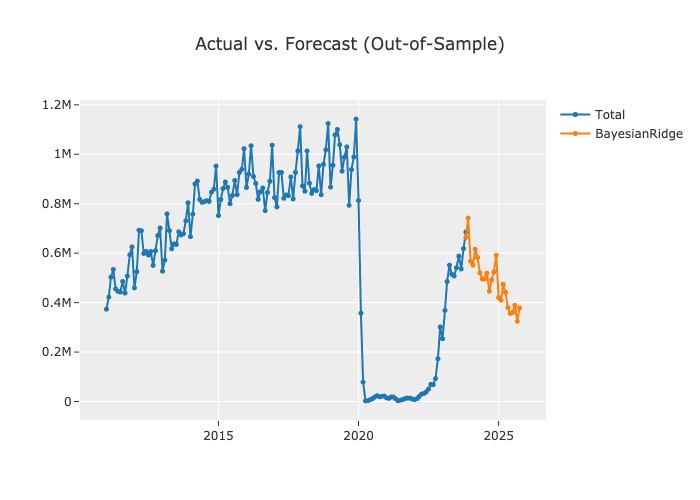

In [32]:
# Use the plot_model() function to plot the best model’s (Bayesian Ridge) forecast
plot_model(best, plot = 'forecast', data_kwargs = {'fh' : 24}, fig_kwargs = {'renderer': 'png'})

Surprisingly, the Bayesian Ridge model predicts another downturn in the next 24 months, which contradicts our expectation and common scenario based on the potential trajectory of the travel industry during a recovery phase post-pandemic. As far as we understand, there has been a notable surge in visitor numbers, marking a robust rebound following the global pandemic.

Since most top performers on the aformentioned table of performance metrics yield a similar downtrend. We will further look into other alternatives that potentially can forecast a more reasonable outcome in our case.

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2023-05,0.1110,0.0587,17927.7553,17927.7553,0.0353,0.0359
1,2023-06,0.3142,0.1676,51457.2112,51457.2112,0.0951,0.0998
2,2023-07,0.3453,0.1858,57375.3973,57375.3973,0.0976,0.1026
3,2023-08,0.1222,0.0663,20614.0728,20614.0728,0.0384,0.0377
4,2023-09,0.4956,0.2712,84640.0608,84640.0608,0.1369,0.1470
Mean,NaT,0.2777,0.1499,46402.8995,46402.8995,0.0807,0.0846
SD,NaT,0.1452,0.0795,24835.1352,24835.1352,0.0387,0.0425


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2023-05,0.1800,0.0952,29085.4564,29085.4564,0.0573,0.0557
1,2023-06,0.0899,0.0480,14725.4669,14725.4669,0.0272,0.0276
2,2023-07,0.0610,0.0328,10135.7578,10135.7578,0.0172,0.0174
3,2023-08,0.2299,0.1248,38782.7768,38782.7768,0.0723,0.0698
4,2023-09,0.0526,0.0288,8975.6960,8975.6960,0.0145,0.0144
Mean,NaT,0.1227,0.0659,20341.0308,20341.0308,0.0377,0.0370
SD,NaT,0.0701,0.0377,11674.0393,11674.0393,0.0230,0.0219


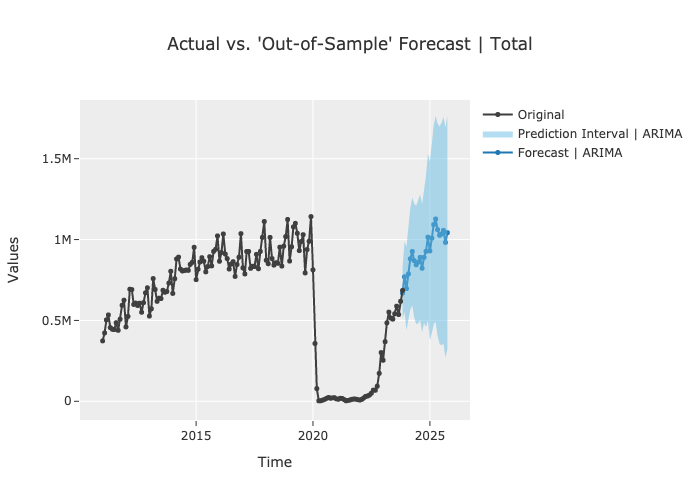

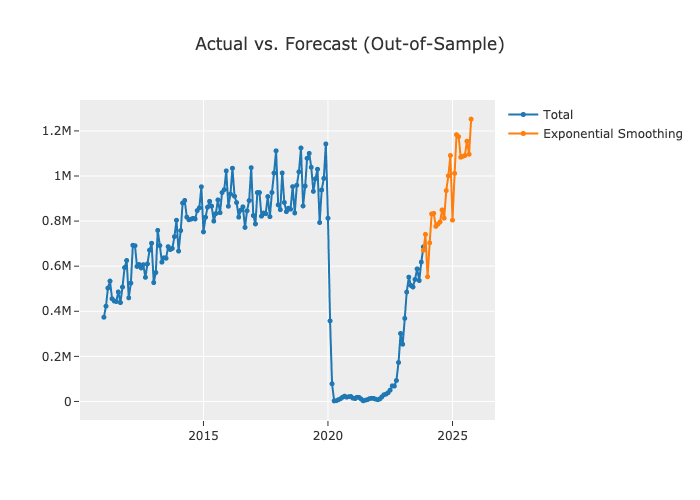

In [33]:
# Use the create_model() function to generate additional models of interest and plot them
arima = create_model('arima')
exp_smooth = create_model('exp_smooth')
plot_model(arima, plot = 'forecast', data_kwargs = {'fh' : 24}, fig_kwargs = {'renderer': 'png'})
plot_model(exp_smooth, plot = 'forecast', data_kwargs = {'fh' : 24}, fig_kwargs = {'renderer': 'png'})

In [34]:
# Look into the seasonal order of our SARIMA model
arima

ARIMA(seasonal_order=(0, 1, 0, 12))


Both the **SARIMA and Exponential Smoothing** models anticipate an upward trend in the number of incoming visitors to Taiwan over the next 24 months. This forecast appears more plausible than that generated by the Bayesian Ridge model, despite a slightly higher error score. The key takeaway is that selecting the best model cannot be solely determined by performance metrics. In addition to model fitness, ensuring the resulting forecast is meaningful and sensible is equally crucial. We should always use our best discretion and leverage domain knowledge to choose the most appropriate model for our specific case.